# 🎥**영화리뷰 텍스트 감성분석하기❣**


## 목차


[1. 데이터 준비 및 확인](#1-데이터-준비-및-확인)

[2. 데이터로더 구성](#2-데이터로더-구성)

[3. 모델 구성을 위한 데이터 분석 및 가공](#3-모델-구성을-위한-데이터-분석-및-가공)

[4. 모델구성 및 validation set 구성](#4-모델구성-및-validation-set-구성)

[5. 모델 훈련 개시](#5-모델-훈련-개시)

[6. Loss, Accuracy 그래프 시각화](#6-Loss-Accuracy-그래프-시각화)

[7. 학습된 Embedding 레이어 분석](#7-학습된-Embedding-레이어-분석)

[8. 한국어 Word2Vec 임베딩 활용하여 성능 개선](#8-한국어-Word2Vec-임베딩-활용하여-성능-개선)

[9. Dropout, Bidirectional layer](#9-Dropout-Bidirectional-layer)

[회고](#회고)

[번외. 리뷰 예측해보기](#번외-리뷰-예측해보기)




## 1. 데이터 준비 및 확인

In [15]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성


이번 nsmc 데이터셋은 가공되지 않은 텍스트 파일이여서 아래의 항목을 진행할 것이다.


- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopworde)제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import konlpy
from konlpy.tag import Mecab
from konlpy.tag import Okt
import numpy as np
from collections import Counter
import re

tokenizer = Mecab()
stopwords = [
    '의', '가', '이', '은', '들', 
    '는', '좀', '잘', '걍', '과', 
    '도', '를', '와', '자', '에', 
    '한', '으로', '하다'
]

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
    train_data['document'].replace('', np.nan, regex=True)
    train_data = train_data.dropna(how = 'any')
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
    test_data['document'].replace('', np.nan, regex=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {
        word:index for index, word in enumerate(vocab)
        }
    
    # {단어:숫자} 딕셔너리
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data number: {len(X_train)}, test data number: {len(X_test)}')
print(f'test data number:  {len(y_train)}, test data number: {len(y_test)}')

train data number: 143682, test data number: 48418
test data number:  143682, test data number: 48418


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

딕셔너리를 변수 `index_to_word`로 만들어준다.

In [6]:
def get_encoded_sentence(sentence, word_to_index): # -----(1)
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index): # -----(2)
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word): # -----(3)
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word): # -----(14)
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수이다.   



1. 모든 문장은 <BOS>로 시작   
2. 여러 개의 문장 리스트를 한번에 단어 인덱스 리스트 벡터로 encode해주는 함수
3. 숫자 벡터로 encode된 문장을 원래대로 decode해주는 함수   
4. 여러 개의 숫자 벡터로 encode된 문장을 한번에 원래대로 decode해주는 함수

In [7]:
for i in range(4):
    label = y_train[i]
    encode = X_train[i]
    decode = get_decoded_sentence(X_train[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

label: 0
    encode: [27, 67, 911, 33, 215, 15, 28, 698]
    decode: 더 빙 진짜 짜증 나 네요 목소리
label: 1
    encode: [992, 481, 328, 632, 4, 110, 1550, 47, 789, 952, 11, 38, 368]
    decode: 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
label: 0
    encode: [19, 192, 2]
    decode: 재 <UNK>
label: 0
    encode: [8023, 143, 3973, 278, 86, 13, 5, 50, 3318]
    decode: 이야기 구먼 솔직히 재미 없 다 평점 조정


## 3. 모델 구성을 위한 데이터 분석 및 가공


- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### ▶ 문장 길이 분포 및 지정


- `pad_squences` 를 통해 데이터셋 상의 문장의 길이를 통일해야한다.   
- 문장 최대 길이 `maxlen` 의 값 설정도 전체 성능에 영향을 미치기때문에   
적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인하는 것도 좋다.

In [8]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.924653826132223
문장길이 최대 :  83
문장길이 표준편차 :  11.45644660737657
pad_sequences maxlen :  36
전체 문장의 0.9328474752732951%가 maxlen 설정값 이내에 포함됩니다. 


pad_sequences maxlen :  36 인 것을 알아내었다.

### ▶ keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


- padding 방식을 문장 뒤쪽('post')과 앞쪽('pre')중 선택에 따라 RNN을 이용한 딥러닝 적용 시 성능차이가 있다.

In [9]:
import tensorflow as tf

X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(f'X_train_post: {X_train_post.shape}')
print(f'X_test_post: {X_test_post.shape}')

X_train_post: (143682, 36)
X_test_post: (48418, 36)


In [10]:
import tensorflow as tf

X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(f'X_train_pre: {X_train_post.shape}')
print(f'X_test_pre:  {X_test_pre.shape}')

X_train_pre: (143682, 36)
X_test_pre:  (48418, 36)


In [11]:
print('<X_train_post>\n')

for i in range(4):
    label = y_train[i]
    encode = X_train_post[i]
    decode = get_decoded_sentence(X_train[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

<X_train_post>

label: 0
    encode: [ 27  67 911  33 215  15  28 698   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
    decode: 더 빙 진짜 짜증 나 네요 목소리
label: 1
    encode: [ 992  481  328  632    4  110 1550   47  789  952   11   38  368    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
    decode: 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
label: 0
    encode: [ 19 192   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
    decode: 재 <UNK>
label: 0
    encode: [8023  143 3973  278   86   13    5   50 3318    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
    decode: 이야기 구먼 솔직히 재미 없 다 평점 조정


In [12]:
print('<X_train_pre>\n')

for i in range(4):
    label = y_train[i]
    encode = X_train_pre[i]
    decode = get_decoded_sentence(X_train[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

<X_train_pre>

label: 0
    encode: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  27  67 911  33 215  15  28 698]
    decode: 더 빙 진짜 짜증 나 네요 목소리
label: 1
    encode: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  992  481  328  632    4
  110 1550   47  789  952   11   38  368]
    decode: 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
label: 0
    encode: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19 192   2]
    decode: 재 <UNK>
label: 0
    encode: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 8023
  143 3973  278   86   13    5   50 3318]
    decode: 이야기 구먼 솔직히 재미 없 다 평점 조정


## 4. 모델구성 및 validation set 구성


- 적절한 학습을 위해 train set과 val set을 구분한다.
- 1/3으로 train set(100577), val set(43105)로 정하였다.
- 모델구성은 다양한 모델로 성능차이를 비교하기 위해 3가지의 모델을 사용하였다.
    - Recurrent Neural Networ(RNN)
    - 1-D Convolution Neural Network(1-D CNN)
    - GlobalMaxPooling1D

### ▶ Validation set

- 적절한 학습을 위해 train set과 val set을 구분한다.
- 1/3으로 train set(95788), val set(47894)로 정하였다.

In [13]:
X_val_post = X_train_post[:47894]
X_val_pre = X_train_pre[:47894]
y_val = y_train[:47894]

partial_X_train_post = X_train_post[47894:]
partial_X_train_pre = X_train_pre[47894:]
partial_y_train = y_train[47894:]

print(f'X_val_post: {X_val_post.shape}')
print(f'X_val_pre:  {X_val_pre.shape}')
print(f'y_val: {y_val.shape}')
print()
print(f'partial_X_train_post: {partial_X_train_post.shape}')
print(f'partial_X_train_pre:  {partial_X_train_pre.shape}')
print(f'partial_y_train:      {partial_y_train.shape}')

X_val_post: (47894, 36)
X_val_pre:  (47894, 36)
y_val: (47894,)

partial_X_train_post: (95788, 36)
partial_X_train_pre:  (95788, 36)
partial_y_train:      (95788,)


### ▶ 모델 구성

- 모델구성은 다양한 모델로 성능차이를 비교하기 위해 3가지의 모델을 사용하였다.
    - Recurrent Neural Networ(RNN)
    - 1-D Convolution Neural Network(1-D CNN)
    - GlobalMaxPooling1D(레이어)

### **Recurrent Neural Networ(RNN)**

- **post_modelR(RNN)**

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
post_modelR = keras.Sequential()
post_modelR.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
post_modelR.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
post_modelR.add(keras.layers.Dense(8, activation='relu'))
post_modelR.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

post_modelR.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


- **pre_modelR(RNN)**

In [17]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
pre_modelR = keras.Sequential()
pre_modelR.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
pre_modelR.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
pre_modelR.add(keras.layers.Dense(8, activation='relu'))
pre_modelR.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

pre_modelR.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### **1-D Convolution Neural Network(1-D CNN)**

- **post_modelC(1-D CNN)**

In [18]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
post_modelC = keras.Sequential()
post_modelC.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
post_modelC.add(keras.layers.Conv1D(16, 3, activation='relu'))
post_modelC.add(keras.layers.MaxPooling1D(5))
post_modelC.add(keras.layers.Conv1D(16, 3, activation='relu'))
post_modelC.add(keras.layers.GlobalMaxPooling1D())
post_modelC.add(keras.layers.Dense(8, activation='relu'))
post_modelC.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

post_modelC.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

- **pre_modelC(1-D CNN)**

In [19]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
pre_modelC = keras.Sequential()
pre_modelC.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
pre_modelC.add(keras.layers.Conv1D(16, 3, activation='relu')) # 7
pre_modelC.add(keras.layers.MaxPooling1D(5))
pre_modelC.add(keras.layers.Conv1D(16, 3, activation='relu'))
pre_modelC.add(keras.layers.GlobalMaxPooling1D())
pre_modelC.add(keras.layers.Dense(8, activation='relu'))
pre_modelC.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

pre_modelC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### **GlobalMaxPooling1D**

- **post_modelG(GlobalMaxPooling1D)**

In [20]:
vocab_size = 10000
word_vector_dim = 16

post_modelG = keras.Sequential()
post_modelG.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
post_modelG.add(keras.layers.GlobalMaxPooling1D())
post_modelG.add(keras.layers.Dense(8, activation='relu'))
post_modelG.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

post_modelG.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


- **pre_modelG(GlobalMaxPooling1D)**

In [21]:
vocab_size = 10000
word_vector_dim = 16

pre_modelG = keras.Sequential()
pre_modelG.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
pre_modelG.add(keras.layers.GlobalMaxPooling1D())
pre_modelG.add(keras.layers.Dense(8, activation='relu'))
pre_modelG.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

pre_modelG.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

- **post_modelR_history(RNN)**

In [22]:
post_modelR.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

post_modelR_history = post_modelR.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 7s 27ms/step - loss: 0.6024 - accuracy: 0.6692 - val_loss: 0.4674 - val_accuracy: 0.8209
Epoch 2/5
188/188 [==============================] - 4s 21ms/step - loss: 0.3975 - accuracy: 0.8397 - val_loss: 0.3789 - val_accuracy: 0.8389
Epoch 3/5
188/188 [==============================] - 4s 24ms/step - loss: 0.3426 - accuracy: 0.8599 - val_loss: 0.3639 - val_accuracy: 0.8414
Epoch 4/5
188/188 [==============================] - 5s 28ms/step - loss: 0.3219 - accuracy: 0.8696 - val_loss: 0.3705 - val_accuracy: 0.8366
Epoch 5/5
188/188 [==============================] - 5s 24ms/step - loss: 0.3127 - accuracy: 0.8720 - val_loss: 0.3893 - val_accuracy: 0.8333


- **pre_modelR_history(RNN)**

In [23]:
pre_modelR.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

pre_modelR_history = pre_modelR.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 6s 22ms/step - loss: 0.6122 - accuracy: 0.6291 - val_loss: 0.4225 - val_accuracy: 0.8172
Epoch 2/5
188/188 [==============================] - 4s 20ms/step - loss: 0.3747 - accuracy: 0.8390 - val_loss: 0.3791 - val_accuracy: 0.8303
Epoch 3/5
188/188 [==============================] - 4s 20ms/step - loss: 0.3355 - accuracy: 0.8585 - val_loss: 0.3610 - val_accuracy: 0.8412
Epoch 4/5
188/188 [==============================] - 4s 20ms/step - loss: 0.3201 - accuracy: 0.8666 - val_loss: 0.3641 - val_accuracy: 0.8398
Epoch 5/5
188/188 [==============================] - 5s 26ms/step - loss: 0.3124 - accuracy: 0.8705 - val_loss: 0.3689 - val_accuracy: 0.8390


- **post_modelC_history(CNN)**

In [24]:
post_modelC.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

post_modelC_history = post_modelC.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 3s 13ms/step - loss: 0.5221 - accuracy: 0.7452 - val_loss: 0.3843 - val_accuracy: 0.8294
Epoch 2/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3460 - accuracy: 0.8503 - val_loss: 0.3611 - val_accuracy: 0.8417
Epoch 3/5
188/188 [==============================] - 2s 11ms/step - loss: 0.3039 - accuracy: 0.8728 - val_loss: 0.3633 - val_accuracy: 0.8405
Epoch 4/5
188/188 [==============================] - 2s 10ms/step - loss: 0.2719 - accuracy: 0.8890 - val_loss: 0.3734 - val_accuracy: 0.8407
Epoch 5/5
188/188 [==============================] - 2s 11ms/step - loss: 0.2421 - accuracy: 0.9052 - val_loss: 0.3884 - val_accuracy: 0.8374


- **pre_modelC_history(CNN)**

In [25]:
pre_modelC.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

pre_modelC_history = pre_modelC.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 3s 12ms/step - loss: 0.5368 - accuracy: 0.7295 - val_loss: 0.3747 - val_accuracy: 0.8334
Epoch 2/5
188/188 [==============================] - 2s 11ms/step - loss: 0.3468 - accuracy: 0.8504 - val_loss: 0.3588 - val_accuracy: 0.8415
Epoch 3/5
188/188 [==============================] - 2s 11ms/step - loss: 0.3075 - accuracy: 0.8697 - val_loss: 0.3618 - val_accuracy: 0.8418
Epoch 4/5
188/188 [==============================] - 2s 10ms/step - loss: 0.2799 - accuracy: 0.8849 - val_loss: 0.3716 - val_accuracy: 0.8422
Epoch 5/5
188/188 [==============================] - 2s 11ms/step - loss: 0.2546 - accuracy: 0.8967 - val_loss: 0.3861 - val_accuracy: 0.8402


- **post_modelG_history(GlobalMaxPooling1D)**

In [26]:
post_modelG.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

post_modelG_history = post_modelG.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 1s 5ms/step - loss: 0.6497 - accuracy: 0.6517 - val_loss: 0.5426 - val_accuracy: 0.7945
Epoch 2/5
188/188 [==============================] - 1s 5ms/step - loss: 0.4506 - accuracy: 0.8197 - val_loss: 0.4005 - val_accuracy: 0.8246
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.3600 - accuracy: 0.8489 - val_loss: 0.3744 - val_accuracy: 0.8333
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.3230 - accuracy: 0.8657 - val_loss: 0.3699 - val_accuracy: 0.8363
Epoch 5/5
188/188 [==============================] - 1s 4ms/step - loss: 0.2983 - accuracy: 0.8773 - val_loss: 0.3727 - val_accuracy: 0.8370


- **pre_modelG_history(GlobalMaxPooling1D)**

In [27]:
pre_modelG.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

pre_modelG_history = pre_modelG.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 2s 6ms/step - loss: 0.6426 - accuracy: 0.6900 - val_loss: 0.5481 - val_accuracy: 0.7880
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4524 - accuracy: 0.8197 - val_loss: 0.3964 - val_accuracy: 0.8280
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.3582 - accuracy: 0.8497 - val_loss: 0.3704 - val_accuracy: 0.8350
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.3214 - accuracy: 0.8663 - val_loss: 0.3661 - val_accuracy: 0.8373
Epoch 5/5
188/188 [==============================] - 1s 4ms/step - loss: 0.2968 - accuracy: 0.8778 - val_loss: 0.3683 - val_accuracy: 0.8385


## 6. Loss, Accuracy 그래프 시각화

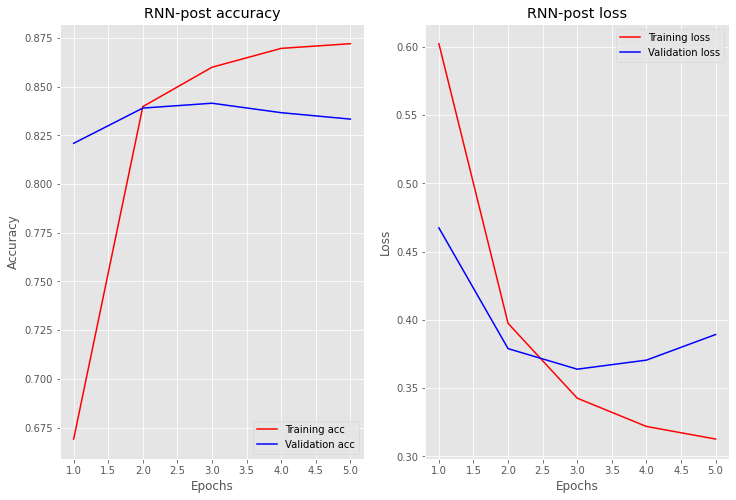

1514/1514 - 4s - loss: 0.4592 - accuracy: 0.7735
[0.45915699005126953, 0.7734726667404175]


In [63]:
post_modelR_dict = post_modelR_history.history

acc = post_modelR_dict['accuracy']
val_acc = post_modelR_dict['val_accuracy']
loss = post_modelR_dict['loss']
val_loss = post_modelR_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.style.use('ggplot')
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN-post accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN-post loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = post_modelR.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

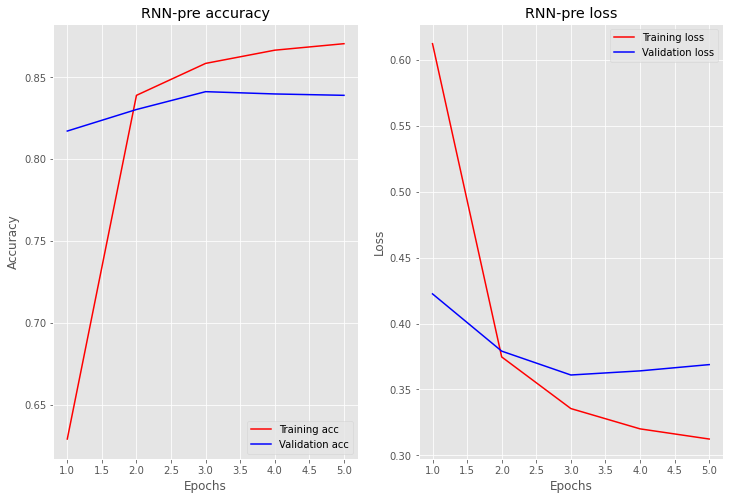

1514/1514 - 3s - loss: 0.4088 - accuracy: 0.8323
[0.4088232219219208, 0.8323144316673279]


In [29]:
pre_modelR_dict = pre_modelR_history.history

acc = pre_modelR_dict['accuracy']
val_acc = pre_modelR_dict['val_accuracy']
loss = pre_modelR_dict['loss']
val_loss = pre_modelR_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN-pre accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN-pre loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = pre_modelR.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

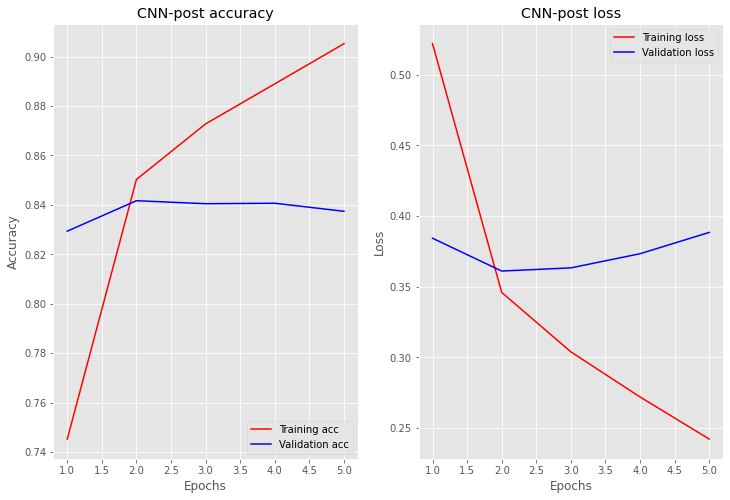

1514/1514 - 1s - loss: 0.6170 - accuracy: 0.6781
[0.6170265674591064, 0.6780742406845093]


In [30]:
post_modelC_dict = post_modelC_history.history

acc = post_modelC_dict['accuracy']
val_acc = post_modelC_dict['val_accuracy']
loss = post_modelC_dict['loss']
val_loss = post_modelC_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN-post accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN-post loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = post_modelC.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

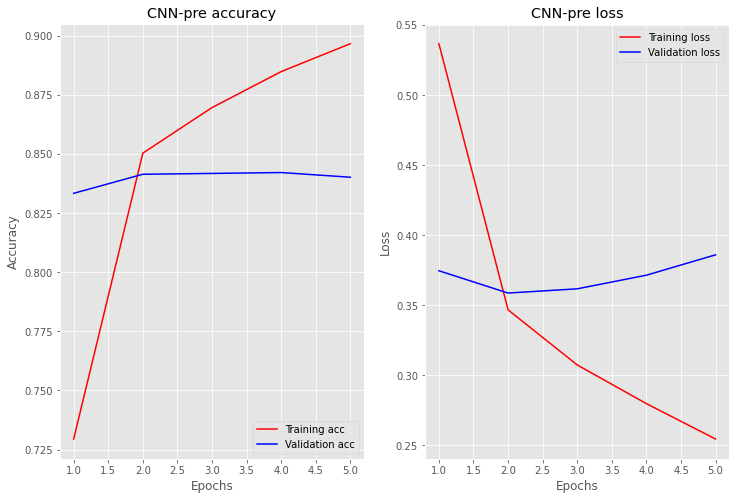

1514/1514 - 1s - loss: 0.5517 - accuracy: 0.6996
[0.5517095923423767, 0.6995952129364014]


In [31]:
pre_modelC_dict = pre_modelC_history.history

acc = pre_modelC_dict['accuracy']
val_acc = pre_modelC_dict['val_accuracy']
loss = pre_modelC_dict['loss']
val_loss = pre_modelC_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN-pre accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN-pre loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = pre_modelC.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

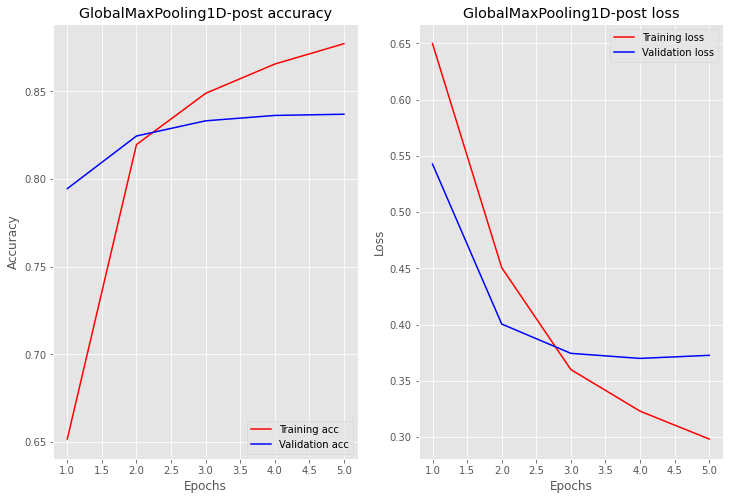

1514/1514 - 1s - loss: 0.3798 - accuracy: 0.8344
[0.3797963261604309, 0.8343797922134399]


In [32]:
post_modelG_dict = post_modelG_history .history

acc = post_modelG_dict['accuracy']
val_acc = post_modelG_dict['val_accuracy']
loss = post_modelG_dict['loss']
val_loss = post_modelG_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D-post accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D-post loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = post_modelG.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

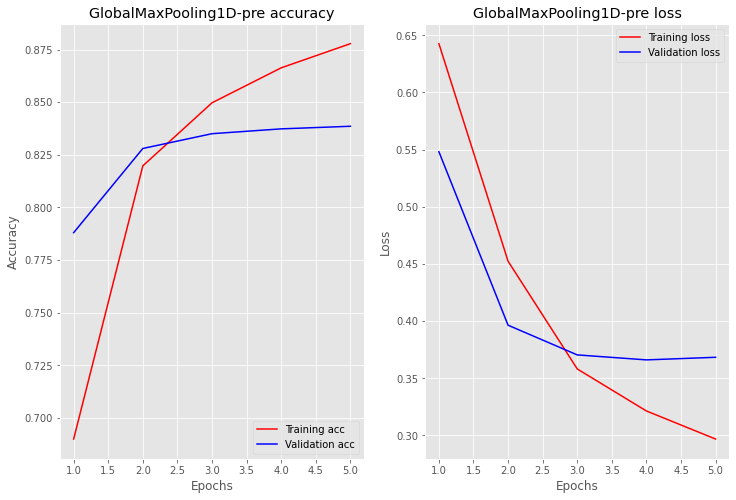

1514/1514 - 1s - loss: 0.3783 - accuracy: 0.8351
[0.37827903032302856, 0.8350819945335388]


In [33]:
pre_modelG_dict = pre_modelG_history .history

acc = pre_modelG_dict['accuracy']
val_acc = pre_modelG_dict['val_accuracy']
loss = pre_modelG_dict['loss']
val_loss = pre_modelG_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D-pre accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.style.use('ggplot')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D-pre loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = pre_modelG.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

,Model,Post-acc,Post-loss,Pre-acc,pre-loss
RNN,RNN,0.8282,0.4237,0.7634,0.4680
CNN,CNN,0.6658,0.6211,0.7109,0.5417
GlobalMaxPooling,GlobalMaxPooling,0.8355,0.3762,0.8370,0.3745


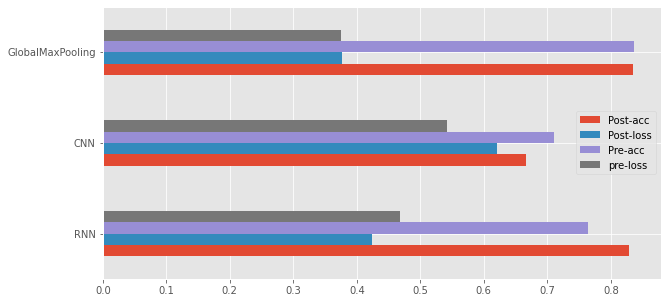

In [34]:
import matplotlib.pyplot as plt

result_dict = {
    "Model": ['RNN', 'CNN', 'GlobalMaxPooling'], 
    "Post-acc": [0.8282, 0.6658, 0.8355], 
    "Post-loss": [0.4237, 0.6211, 0.3762],
    "Pre-acc": [0.7634, 0.7109, 0.8370],
    "pre-loss": [0.4680, 0.5417, 0.3745]
}

result_df = pd.DataFrame(result_dict, index=['RNN', 'CNN', 'GlobalMaxPooling'])
result_df.plot.barh(figsize=(10, 5))
result_df

> ## **중간 점검**   
    - 각 모델별 감정분석의 경우 GlobalMaxPooling이 낮은 loss와 높은 accuracy 값이 나왔다.   
    - GlobalMaxPooling에서 Post와 Pre를 다르게 주었을 때 accuracy 값은 차이가 거의 없다.   
    - 각 모델별 Post와 Pre를 비교했을 때 Pre가 더 높은 accuracy가 나온다는 것을 알게되었다.   

## 7. 학습된 Embedding 레이어 분석

### Embedding 레이어


이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터이다.   
만약 감성 분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 워드 벡터들도 의미 공간상에 유의미한 형태로 학습이 될 것이다.   
아 레이어를 이용하여 더욱 의미있는 insight를 도출해보자.

In [35]:
embedding_modelR_layer = pre_modelR.layers[0]
weights = embedding_modelR_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [36]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_n1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = embedding_modelR_layer.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("행복")

[('본방', 0.9565442800521851),
 ('혁', 0.9308539628982544),
 ('에요', 0.9280765056610107),
 ('느꼈', 0.9248202443122864),
 ('에유', 0.9242799282073975),
 ('워리어', 0.9215296506881714),
 ('경이롭', 0.9165802001953125),
 ('잊혀', 0.9114049077033997),
 ('설레이', 0.908747673034668),
 ('이루어지', 0.9060937762260437)]

In [38]:
word_vectors.similar_by_word("행복")

[('본방', 0.9565442800521851),
 ('혁', 0.9308539628982544),
 ('에요', 0.9280765056610107),
 ('느꼈', 0.9248202443122864),
 ('에유', 0.9242799282073975),
 ('워리어', 0.9215296506881714),
 ('경이롭', 0.9165802001953125),
 ('잊혀', 0.9114049077033997),
 ('설레이', 0.908747673034668),
 ('이루어지', 0.9060937762260437)]

In [39]:
word_vectors.similar_by_word("피곤")

[('나대', 0.9676816463470459),
 ('거늘', 0.9655888080596924),
 ('농장', 0.9632774591445923),
 ('다이애나', 0.9577396512031555),
 ('진상', 0.9575539231300354),
 ('개판', 0.9566992521286011),
 ('추격자', 0.956298828125),
 ('엽기', 0.9558898210525513),
 ('그라', 0.9554671049118042),
 ('강조', 0.9552105665206909)]

훈련데이터로는 조금 많이 이상하게 나온다.. 한국어 Word2Vec 임베딩 개선을 해보자.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [40]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = '~/aiffel/sentiment_classification/data/ko_1.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['행복']
vector.shape     # 200dim의 워드 벡터

<ipython-input-40-15b4bbb833bb>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['행복']


(200,)

In [41]:
word2vec.similar_by_word("행복")

<ipython-input-41-4815e6f10dc1>:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759076714515686),
 ('기쁨', 0.6493781208992004),
 ('즐거움', 0.6396492123603821),
 ('삶', 0.629989743232727),
 ('젊음', 0.6187378168106079),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [42]:
word2vec.similar_by_word("사랑")

<ipython-input-42-057e054a0a3c>:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759076714515686),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458413600921631),
 ('이별', 0.63347989320755),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063885688782),
 ('유혹', 0.5965287685394287)]

In [43]:
word2vec.similar_by_word("결혼")

<ipython-input-43-571d2b6b4101>:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("결혼")


[('재혼', 0.8602977395057678),
 ('약혼', 0.8294124603271484),
 ('혼인', 0.8150443434715271),
 ('동침', 0.71473228931427),
 ('사별', 0.7103983163833618),
 ('이혼', 0.6888261437416077),
 ('재회', 0.6457901000976562),
 ('결별', 0.6362688541412354),
 ('교제', 0.6243670582771301),
 ('헤어지', 0.6122137904167175)]

Embedding을 통해 워드 벡터의 유사도가 높은 단어들로 학습이 된 것을 알 수 있다.   
여기서 한글 파일을 받아야됬는데 영어로 실행을 하여 시간을 너무 많이 소비하였다...💦💦💦


각종 모델을 이용하여 학습을 진행해보자.

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

<ipython-input-44-793f5a133719>:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
<ipython-input-44-793f5a133719>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### ▶ 모델 생성

- **modelR(RNN)**

In [45]:
modelR = keras.Sequential()
modelR.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), # Embedding 적용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelR.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
modelR.add(keras.layers.Dense(8, activation='relu'))
modelR.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

modelR.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


- **modelC(1-D CNN)**

In [46]:
modelC = keras.Sequential()
modelC.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), # Embedding 적용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelC.add(keras.layers.Conv1D(16, 3, activation='relu'))
modelC.add(keras.layers.MaxPooling1D(5))
modelC.add(keras.layers.Conv1D(16, 3, activation='relu'))
modelC.add(keras.layers.GlobalMaxPooling1D())
modelC.add(keras.layers.Dense(8, activation='relu'))
modelC.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

modelC.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 34, 16)            9616      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 16)             784       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

- **modelG(GlobalMaxPooling)**

In [47]:
modelG = keras.Sequential()
modelG.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), # Embedding 적용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelG.add(keras.layers.GlobalMaxPooling1D())
modelG.add(keras.layers.Dense(8, activation='relu'))
modelG.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

modelG.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


**post 보다 pre가 더 높은 accuracy 값으로 'pre'를 적용하여 학습시켰다**

- **modelR_history(RNN)**

In [48]:
modelR.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

modelR_history = modelR.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1497/1497 [==============================] - 114s 75ms/step - loss: 0.4188 - accuracy: 0.8033 - val_loss: 0.3568 - val_accuracy: 0.8412
Epoch 2/5
1497/1497 [==============================] - 84s 56ms/step - loss: 0.3113 - accuracy: 0.8650 - val_loss: 0.3333 - val_accuracy: 0.8538
Epoch 3/5
1497/1497 [==============================] - 83s 55ms/step - loss: 0.2638 - accuracy: 0.8879 - val_loss: 0.3352 - val_accuracy: 0.8592
Epoch 4/5
1497/1497 [==============================] - 144s 96ms/step - loss: 0.2207 - accuracy: 0.9088 - val_loss: 0.3576 - val_accuracy: 0.8555
Epoch 5/5
1497/1497 [==============================] - 123s 82ms/step - loss: 0.1777 - accuracy: 0.9283 - val_loss: 0.4087 - val_accuracy: 0.8554


- **modelC_history(1-D CNN)**

In [49]:
modelC.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

modelC_history = modelC.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1497/1497 [==============================] - 39s 26ms/step - loss: 0.5898 - accuracy: 0.6635 - val_loss: 0.5227 - val_accuracy: 0.7223
Epoch 2/5
1497/1497 [==============================] - 37s 25ms/step - loss: 0.4881 - accuracy: 0.7452 - val_loss: 0.5021 - val_accuracy: 0.7313
Epoch 3/5
1497/1497 [==============================] - 38s 25ms/step - loss: 0.4472 - accuracy: 0.7719 - val_loss: 0.4899 - val_accuracy: 0.7413
Epoch 4/5
1497/1497 [==============================] - 40s 27ms/step - loss: 0.4167 - accuracy: 0.7888 - val_loss: 0.4947 - val_accuracy: 0.7372
Epoch 5/5
1497/1497 [==============================] - 38s 25ms/step - loss: 0.3899 - accuracy: 0.8028 - val_loss: 0.5192 - val_accuracy: 0.7379


- **modelG_history(GlobalMaxPooling)**

In [50]:
modelG.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

modelG_history = modelG.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1497/1497 [==============================] - 20s 13ms/step - loss: 0.5960 - accuracy: 0.6822 - val_loss: 0.5001 - val_accuracy: 0.7554
Epoch 2/5
1497/1497 [==============================] - 21s 14ms/step - loss: 0.4700 - accuracy: 0.7760 - val_loss: 0.4491 - val_accuracy: 0.7893
Epoch 3/5
1497/1497 [==============================] - 20s 14ms/step - loss: 0.4148 - accuracy: 0.8106 - val_loss: 0.4388 - val_accuracy: 0.7944
Epoch 4/5
1497/1497 [==============================] - 20s 14ms/step - loss: 0.3778 - accuracy: 0.8314 - val_loss: 0.4758 - val_accuracy: 0.7814
Epoch 5/5
1497/1497 [==============================] - 21s 14ms/step - loss: 0.3476 - accuracy: 0.8481 - val_loss: 0.4071 - val_accuracy: 0.8149


### ▶ Loss, Accuracy 그래프 시각화

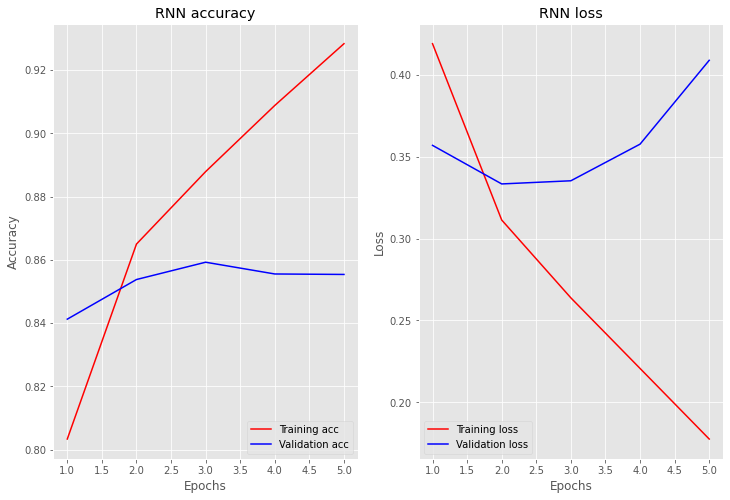

1514/1514 - 11s - loss: 0.4100 - accuracy: 0.8510
[0.40999332070350647, 0.8509851694107056]


In [51]:
modelR_dict = modelR_history.history

acc = modelR_dict['accuracy']
val_acc = modelR_dict['val_accuracy']
loss = modelR_dict['loss']
val_loss = modelR_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = modelR.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

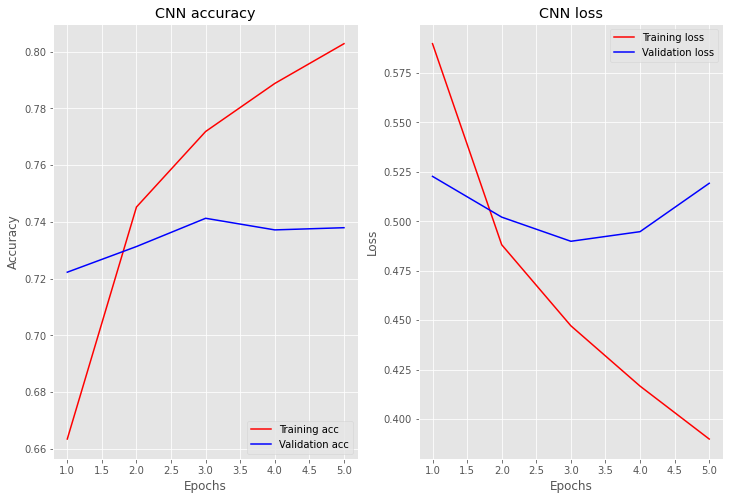

1514/1514 - 2s - loss: 0.5262 - accuracy: 0.7325
[0.5262044072151184, 0.7324962019920349]


In [52]:
modelC_dict = modelC_history.history

acc = modelC_dict['accuracy']
val_acc = modelC_dict['val_accuracy']
loss = modelC_dict['loss']
val_loss = modelC_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = modelC.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

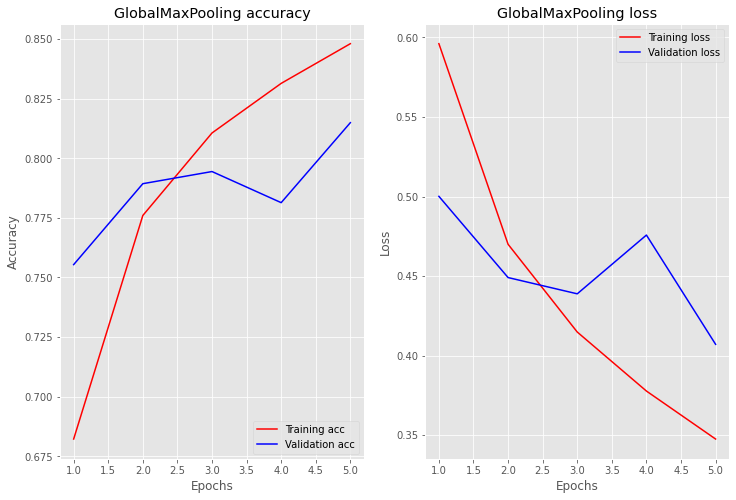

1514/1514 - 1s - loss: 0.4170 - accuracy: 0.8102
[0.4170285761356354, 0.810235857963562]


In [53]:
modelG_dict = modelG_history.history

acc = modelG_dict['accuracy']
val_acc = modelG_dict['val_accuracy']
loss = modelG_dict['loss']
val_loss = modelG_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = modelG.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

,Model,Pre-acc,Pre-loss
RNN,RNN,0.8510,0.4100
CNN,CNN,0.7325,0.5262
GlobalMaxPooling,GlobalMaxPooling,0.8102,0.4170


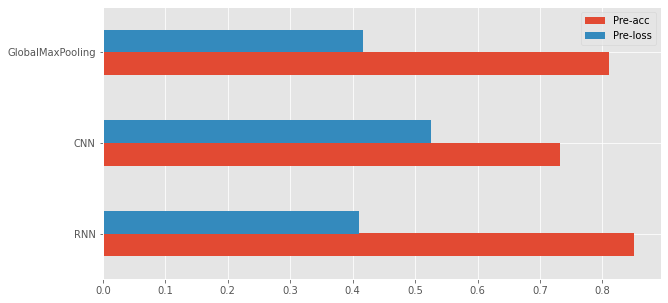

In [62]:
embedding_result_dict = {
    "Model": ['RNN', 'CNN', 'GlobalMaxPooling'], 
    "Pre-acc": [0.8510, 0.7325, 0.8102], 
    "Pre-loss": [0.4100, 0.5262, 0.4170],
}

embedding_result_df = pd.DataFrame(embedding_result_dict, index=['RNN', 'CNN', 'GlobalMaxPooling'])
embedding_result_df.plot.barh(figsize=(10, 5))
embedding_result_df

Embedding이 들어가면서 세 모델('RNN', 'CNN', 'GlobalMaxPooling')이 다 동일하게 나왔다.   
무섭다.....😨😨

**(수정) result에서 모델 이름을 잘못 적어준것때문이였다........**   
**Embedding 했을 경우에는 RNN이 잘나온다.**

## 9. Dropout, Bidirectional layer

  
- hidden layer가 싶어질수록 overfitting 발생을 방지하여 정규화된 모델을 만드는 방법으로 network를 생략시켜 효과를 올릴 수 있다.
- 양방향 LSTM으로 순자적인 입력값에 대해 이전 데이터와의 관계뿐만 아니라 이후 데이터와의 관계까지 학습하여 효과를 증대시킬 수 있다.

In [55]:
modelR_BD = keras.Sequential()
modelR_BD.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), # Embedding 적용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
modelR_BD.add(keras.layers.Bidirectional(keras.layers.LSTM(128, recurrent_dropout=0)))   # Bidirectional layer
modelR_BD.add(keras.layers.Dropout(0.25))
modelR_BD.add(keras.layers.Dense(8, activation='relu'))
modelR_BD.add(keras.layers.Dropout(0.3))
modelR_BD.add(keras.layers.Dense(1, activation='sigmoid'))# 최종 출력은 긍정/부정을 나타내는 1dim

modelR_BD.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,338,961
Trainable params: 2,338,961
Non-trainable params: 0
____________________________________________

In [56]:
modelR_BD.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

modelR_BD_history = modelR_BD.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1497/1497 [==============================] - 157s 103ms/step - loss: 0.4736 - accuracy: 0.7826 - val_loss: 0.3753 - val_accuracy: 0.8242
Epoch 2/5
1497/1497 [==============================] - 145s 97ms/step - loss: 0.3583 - accuracy: 0.8533 - val_loss: 0.3359 - val_accuracy: 0.8518
Epoch 3/5
1497/1497 [==============================] - 186s 124ms/step - loss: 0.3130 - accuracy: 0.8742 - val_loss: 0.3335 - val_accuracy: 0.8580
Epoch 4/5
1497/1497 [==============================] - 155s 104ms/step - loss: 0.2737 - accuracy: 0.8920 - val_loss: 0.3498 - val_accuracy: 0.8563
Epoch 5/5
1497/1497 [==============================] - 142s 95ms/step - loss: 0.2385 - accuracy: 0.9075 - val_loss: 0.3731 - val_accuracy: 0.8535


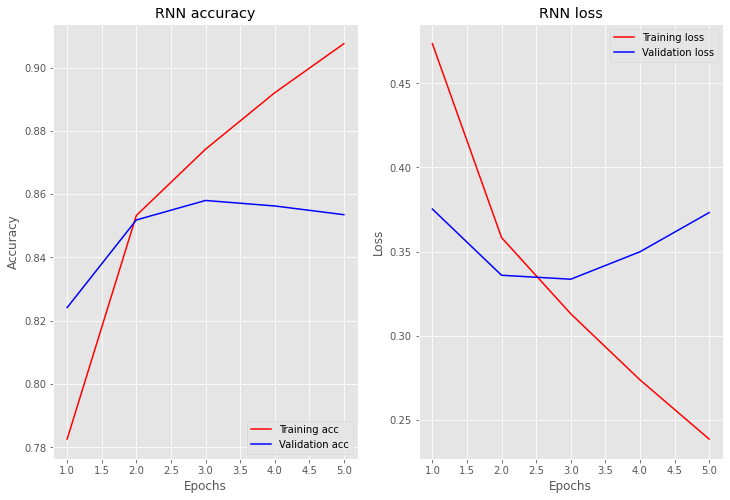

1514/1514 - 23s - loss: 0.3777 - accuracy: 0.8500
[0.37773674726486206, 0.8499731421470642]


In [57]:
modelR_BD_dict = modelR_BD_history.history

acc = modelR_BD_dict['accuracy']
val_acc = modelR_BD_dict['val_accuracy']
loss = modelR_BD_dict['loss']
val_loss = modelR_BD_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# accuracy 그래프
plt.subplot(1,2,1)
plt.style.use('ggplot')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# loss 그래프
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

results = modelR_BD.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

,Model,Pre-acc,Pre-loss
RNN,RNN,0.8511,0.4052
Dropout & Bidirectional layer,Dropout & Bidirectional layer,0.8521,0.3702


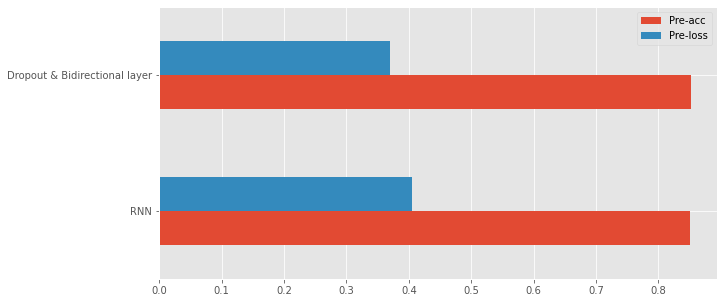

In [58]:
LSTM_dict = {
    "Model": ['RNN', 'Dropout & Bidirectional layer'], 
    "Pre-acc": [0.8511, 0.8521], 
    "Pre-loss": [0.4052, 0.3702]
}

LSTM_result_df = pd.DataFrame(LSTM_dict, index=['RNN', 'Dropout & Bidirectional layer'])
LSTM_result_df.plot.barh(figsize=(10, 5))
LSTM_result_df

## ⛳ 회고 ⛳

### 감성 분석 모델별 결과

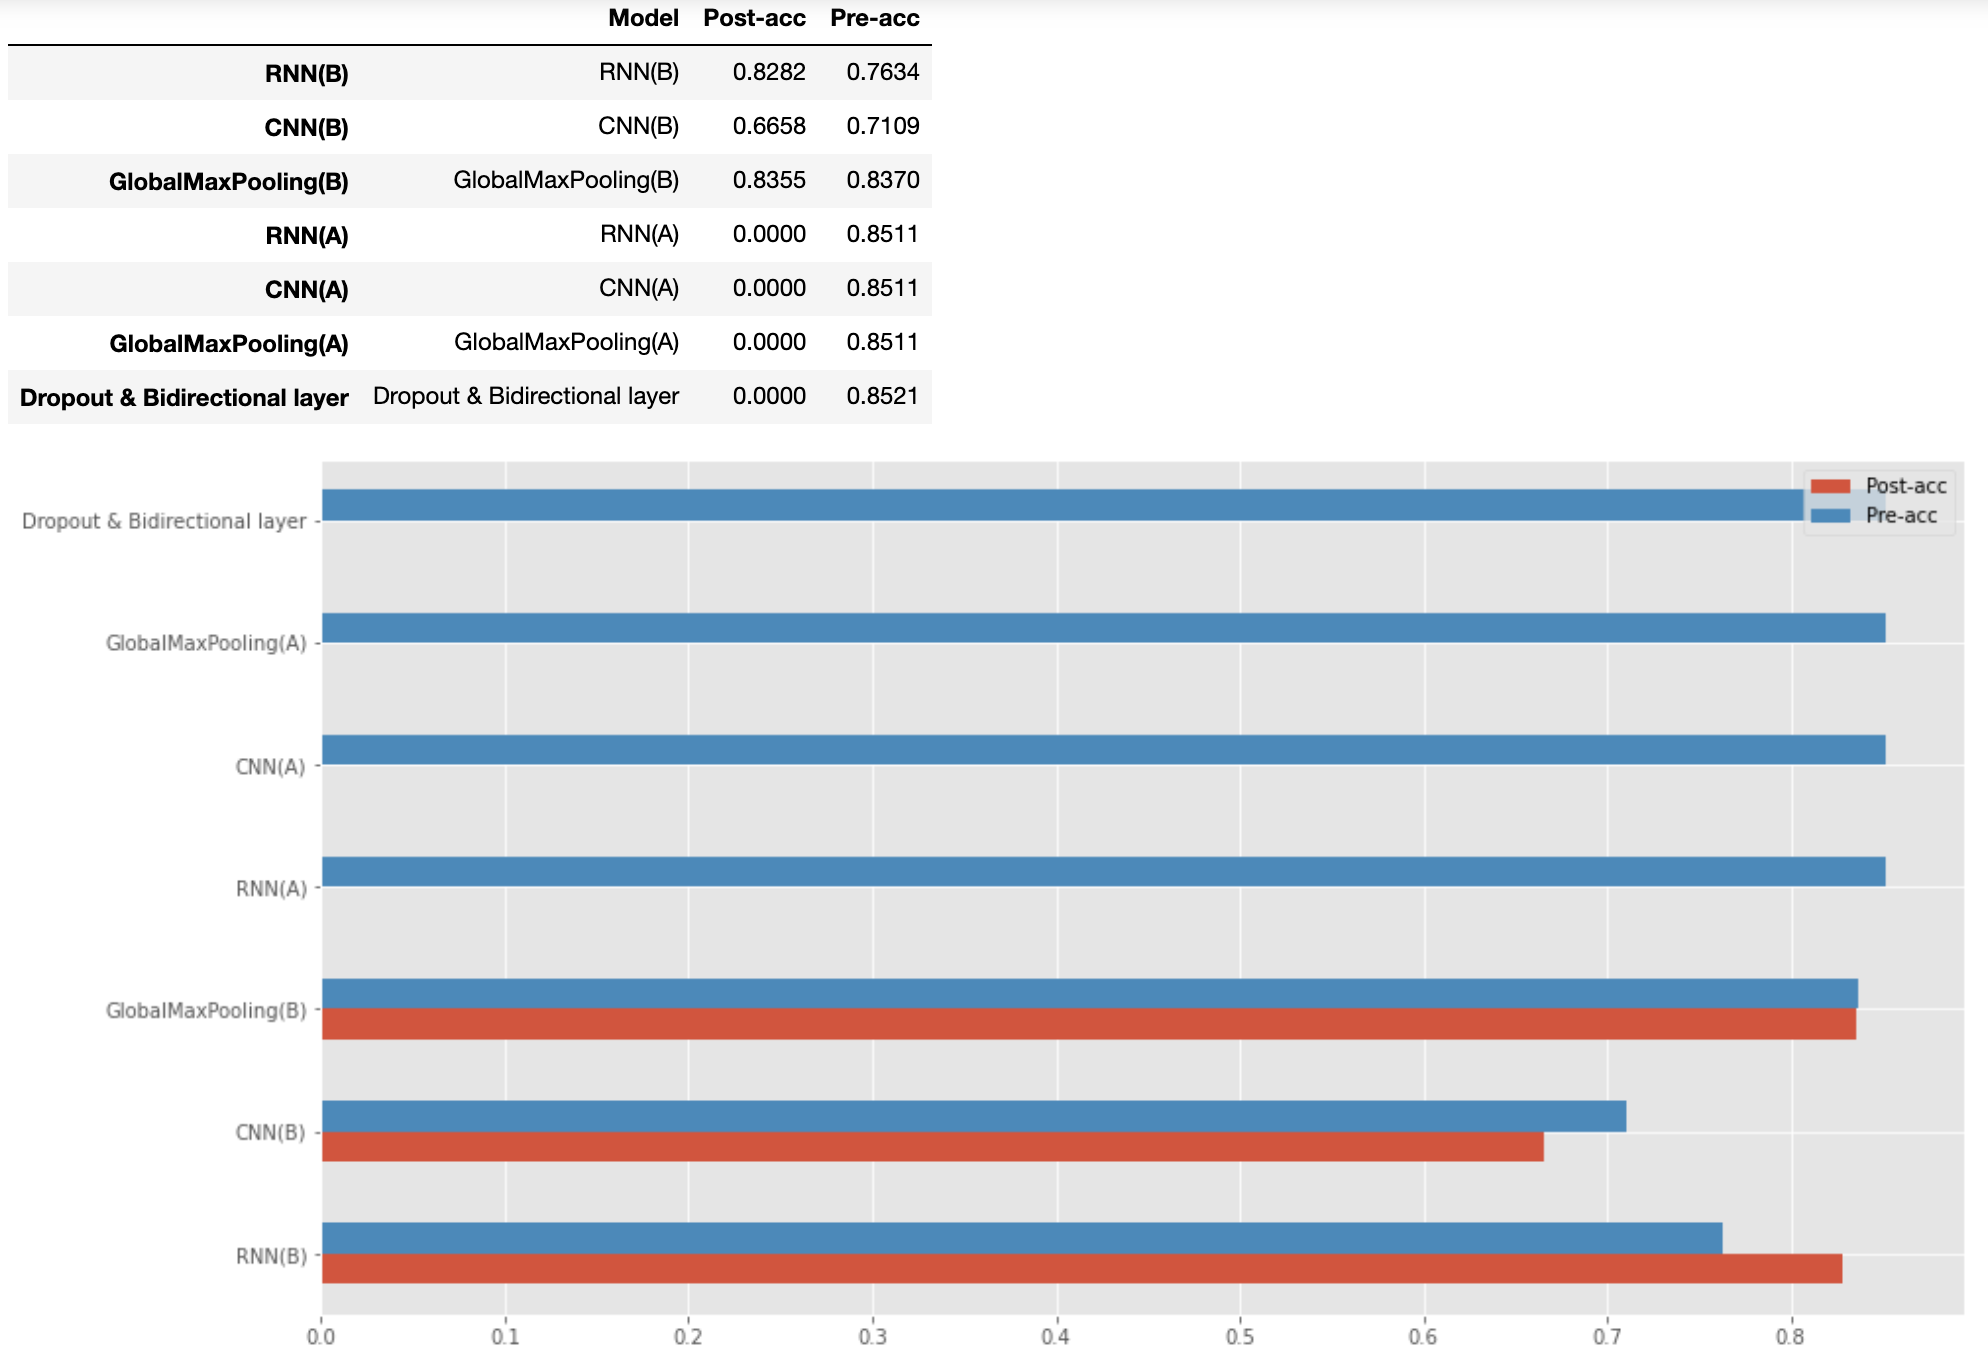

데이터는 위 표와 그래프를 참고하길 바랍니다.

1. 다양한 모델 적용 및 Embedding 활용으로 모델 구현을 실행해보았다.


2. Embedding 전 GlobalMaxPooling은 0.8355로 다른 모델보다 높은 accuracy를 선보였다.   
    - CNN은 재학습이 필요해서인가 패딩에 대해선 영향이 없는 것 같다.
    - 기본적으로 'post' 보다 'pre'가 더 효율적이다.
    
    
    
3. Word2Vec Embedding 활용으로 accuracy는 조금이나마 올랐지만 큰 영향은 없는 것 같다.   


4. 감성 분석으로 단어를 출력했을때는 유사도가 높은 단어를 출력하였다.

## 번외. 리뷰 예측해보기

In [59]:
tokenizer = Mecab()


def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence) # encoding
    new_sentence = [new_sentence]

    new_sentence = keras.preprocessing.sequence.pad_sequences(new_sentence,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen)
    
    score = float(modelR_BD.predict(new_sentence)) # 예측
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [60]:
def scores():
    text_arr = [
    '믿었던 배우였는데 이번엔 실망이 크네요.',
    '자칫 무거울 수 있는 소재를 굉장히 재치있고 흥미롭게 풀어냈다. 올해 본 한국 영화 중 가장 잘 만든 영화! 세심한 연출력과 미장센이 돋보인다.',
    '바다 cg와 캐릭터들간의 캐미를 보는 재미가 쏠쏠하다.',
    '초반에는 좀 지루했지만 점점 몰입이 되고... 마지막에 반전까지.. 정말 좋은 추리영화였다...^^',
    '엔드게임을 뛰어넘는 영화가 죽기전에 나올까 생각했었는데.. 2년만에 나왔습니다',
    '닥터옥토버스가 토비에게 "다컸구나 잘지냈니?" 는 어린시절 스파이더맨보고자란 사람들에게 하는말 같았고 토비의 "애쓰고있죠" 또한 내 상황에 너무 잘들어맞아 울컥했다',
    '삼십 대의 내가 십 대, 이십 대의 나를 만났다'
]
    
    for i in text_arr:
        print(i)
        score = sentiment_predict(i)
        print(score)
    
scores()

믿었던 배우였는데 이번엔 실망이 크네요.
97.49% 확률로 부정 리뷰입니다.

None
자칫 무거울 수 있는 소재를 굉장히 재치있고 흥미롭게 풀어냈다. 올해 본 한국 영화 중 가장 잘 만든 영화! 세심한 연출력과 미장센이 돋보인다.
98.83% 확률로 긍정 리뷰입니다.

None
바다 cg와 캐릭터들간의 캐미를 보는 재미가 쏠쏠하다.
96.78% 확률로 긍정 리뷰입니다.

None
초반에는 좀 지루했지만 점점 몰입이 되고... 마지막에 반전까지.. 정말 좋은 추리영화였다...^^
98.32% 확률로 긍정 리뷰입니다.

None
엔드게임을 뛰어넘는 영화가 죽기전에 나올까 생각했었는데.. 2년만에 나왔습니다
89.92% 확률로 긍정 리뷰입니다.

None
닥터옥토버스가 토비에게 "다컸구나 잘지냈니?" 는 어린시절 스파이더맨보고자란 사람들에게 하는말 같았고 토비의 "애쓰고있죠" 또한 내 상황에 너무 잘들어맞아 울컥했다
98.18% 확률로 긍정 리뷰입니다.

None
삼십 대의 내가 십 대, 이십 대의 나를 만났다
75.57% 확률로 긍정 리뷰입니다.

None


### **"삼십 대의 내가 십 대, 이십 대의 나를 만났다"**   


### 이건 긍정의 말이 아닌가???? ㅋㅋㅋㅋㅋ😅😅😅😅😅😅